# Inference Using Tuned Mask R-CNN

Use Mask R-CNN tuned on the WAD to perform inference.

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 

ROOT_DIR = os.getcwd()
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

from wad_config import WadConfig
from wad_dataset import WadDataset
from wad_dataset_val import WadDatasetVal

print("Making config")
config = WadConfig()
inference_config=config
print("Creating Inference Model")
model = modellib.MaskRCNN(mode="inference",config=inference_config, model_dir=MODEL_DIR)

print(MODEL_DIR)

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Making config
Creating Inference Model
/home/stevenzc/Mask_RCNN/mrcnn/logs


In [2]:
# assumes that the weights are in the mrcnn/logs folder

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = model.find_last()[1]
print(model_path)

# NOTE: overriding with a specific path here
# model_path = '/home/stevenzc/Mask_RCNN/mrcnn/logs/wad20180517T2126/mask_rcnn_wad_0100.h5'

print("Loading weights")
# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

/home/stevenzc/Mask_RCNN/mrcnn/logs/wad20180601T0805/mask_rcnn_wad_0452.h5
Loading weights
Loading weights from  /home/stevenzc/Mask_RCNN/mrcnn/logs/wad20180601T0805/mask_rcnn_wad_0452.h5


In [3]:
# Our WAD Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'car', 'motorcycle', 'bicycle', 'person', 'truck', 'bus', 'tricycle']

print('car', class_names.index('car'))
print('motorcycle', class_names.index('motorcycle'))
print('bicycle', class_names.index('bicycle'))
print('person', class_names.index('person'))
print('truck', class_names.index('truck'))
print('bus', class_names.index('bus'))
print('tricycle', class_names.index('tricycle'))

car 1
motorcycle 2
bicycle 3
person 4
truck 5
bus 6
tricycle 7


## Run Object Detection

Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32


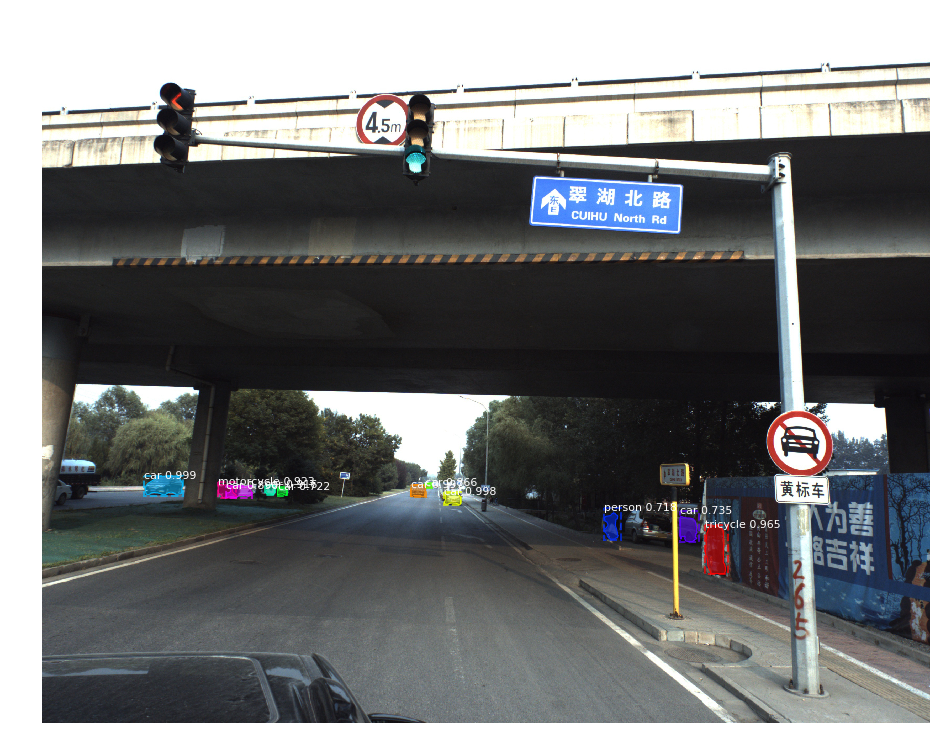

In [4]:
# Load a random image from the images folder
WAD_IM = "/home/stevenzc/cvpr-2018-autonomous-driving/test/92a65b9a2aeafe3a1a5ab1b21e32bbfe.jpg"
image = skimage.io.imread(WAD_IM)

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [13]:
def rle(mask):
    """Produces the WAD challenge run-length encoding format from a binary mask.
    
    Inputs:
        mask - 2D numpy binary mask array
    
    Returns:
        rle_str - RLE string in WAD submission format, zero indexed, | delimited
    """
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    # find locations where the run length changes
    runs = np.where(pixels[1:] != pixels[:-1])[0]
    runs[1::2] -= runs[::2]
    pieces = []
    
    for left, right in zip(runs[::2], runs[1::2]):
        pieces.append(str(left) + ' ' + str(right) + '|')
    
    return ''.join(pieces)

    
sample_mask = np.array([[0, 0, 0],
                       [0, 1, 0],
                       [0, 1, 1]])

print(rle(sample_mask))
print(np.sum(sample_mask))

4 1|7 2|
3


In [6]:
# translate between our class ids (the keys) to wad class ids (the values)

ours_to_wad = {
    1: 33,
    2: 34,
    3: 35,
    4: 36,
    5: 38,
    6: 39,
    7: 40
}

#### Create the submission CSV

Creating the submission CSV took about 2 hours on a single K80 GPU.
Speed is about 3 seconds per image.

In [8]:
import glob
import csv

# NOTE: change the home directory name here
WAD_TEST = "/home/stevenzc/cvpr-2018-autonomous-driving/test/"
filenames = glob.glob(os.path.join(WAD_TEST, '*.jpg'))

# get all the files associated with a particular video
with open('temp.csv', 'w') as outfile:
    writer = csv.writer(outfile)
    # write header row 
    writer.writerow(['ImageId', 'LabelId', 'PixelCount', 'Confidence', 'EncodedPixels'])
    
    rows = 1

    for i, f in enumerate(filenames):
        if i % 10 == 0:
            print('image: ' + str(i) + ', rows: ' + str(rows))
        image = skimage.io.imread(f)
        results = model.detect([image], verbose=0)

        r = results[0]
        class_ids = r['class_ids']
        scores = r['scores']
        masks = r['masks']
        N = len(class_ids)

        image_id = os.path.splitext(os.path.basename(f))[0]

        for n in range(N):
            our_id = class_ids[n]
            if our_id in ours_to_wad:
                # collect object instance information
                wad_id = ours_to_wad[our_id]
                pixel_count = np.sum(masks[:, :, n])
                confid = scores[n]
                rle_str = rle(masks[:, :, n])
                print(rle_str)
                # write instance as row to output
                writer.writerow([image_id, wad_id, pixel_count, confid, rle_str])
                rows += 1

image: 0, rows: 1
5803580 81|5803667 10|5803710 39|5806961 185|5807152 10|5810343 207|5813725 213|5817107 218|5820490 222|5823874 226|5827257 229|5830641 230|5834024 233|5837408 234|5840791 236|5844175 238|5847559 239|5850943 240|5854327 242|5857711 243|5861095 243|5864479 244|5867863 245|5871247 246|5874630 247|5878014 248|5881398 249|5884782 250|5888166 251|5891550 252|5894934 253|5898318 254|5901702 255|5905086 255|5908470 256|5911854 257|5915238 257|5918622 258|5922006 259|5925390 260|5928774 261|5932158 261|5935542 262|5938926 263|5942310 264|5945694 264|5949078 265|5952462 265|5955846 265|5959230 265|5962614 266|5965998 266|5969382 266|5972766 267|5976150 267|5979535 266|5982919 267|5986303 267|5989687 267|5993071 268|5996455 268|5999839 268|6003223 269|6006607 269|6009991 270|6013375 270|6016759 270|6020143 271|6023527 271|6026911 271|6030295 271|6033679 272|6037063 272|6040447 272|6043831 272|6047215 273|6050599 273|6053983 273|6057367 273|6060751 273|6064135 273|6067519 273|60

5807823 26|5807853 5|5811198 51|5814580 52|5817962 54|5821345 55|5824725 58|5828108 58|5831491 58|5834875 58|5838258 58|5841640 60|5845022 61|5848405 62|5851789 61|5855174 59|5858559 58|5861943 57|5865329 55|5868714 55|5872098 55|5875484 53|5878869 52|5882254 51|5885640 49|5889026 47|5892411 46|5895796 45|5899181 44|5902566 43|5905950 43|5909335 43|5912720 42|5916104 42|5919489 41|5922874 40|5926258 41|5929643 40|5933028 39|5936412 39|5939797 38|5943181 38|5946566 37|5949950 37|5953335 36|5956719 36|5960104 35|5963488 35|5966872 35|5970257 34|5973641 34|5977025 34|5980409 34|5983794 33|5987178 33|5990562 33|5993946 33|5997330 33|6000714 33|6004098 33|6007482 33|6010867 32|6014251 32|6017635 32|6021019 32|6024403 32|6027787 32|6031171 32|6034555 32|6037939 32|6041323 32|6044707 32|6048091 33|6051475 33|6054858 34|6058242 34|6061627 33|6065011 33|6068395 33|6071780 32|6075164 32|6078549 30|6081934 29|6085320 27|6088719 9|
5775093 22|5778474 29|5781856 33|5785238 36|5788621 39|5792004 41|

5810735 19|5814119 19|5817503 21|5820887 21|5824271 22|5827655 22|5831039 22|5834423 22|5837807 22|5841191 22|5844575 22|5847959 22|5851343 22|5854727 22|5858117 16|5861514 3|
5801927 15|5805309 20|5805346 21|5808692 24|5808726 27|5812074 65|5815457 66|5818840 68|5822223 69|5825606 70|5828990 71|5832373 72|5835757 73|5839141 73|5842525 74|5845909 75|5849293 76|5852676 77|5856060 78|5859444 79|5862828 80|5866212 80|5869596 81|5872979 83|5876363 83|5879747 84|5883131 84|5886515 85|5889899 87|5893283 87|5896667 88|5900051 91|5903435 88|5906819 87|5910203 87|5913587 87|5916971 87|5920355 86|5923739 86|5927123 86|5930507 86|5933891 85|5937275 85|5940659 82|5944042 81|5947426 78|5950810 76|5954194 76|5957577 76|5960961 75|5964345 75|5967729 75|5971112 76|5974496 48|5974549 22|5977880 47|5977934 21|5981264 47|5981319 20|5984648 46|5984705 17|5988032 45|5988091 15|5991416 41|5991476 14|5994800 40|5994861 12|5998183 40|5998245 12|6001567 40|6001629 12|6004951 40|6005014 10|6008335 40|6008398 3|

5733412 8|5736796 8|5740180 9|5743563 10|5746947 11|5750330 13|5753714 14|5757098 15|5760481 16|5763865 17|5767248 18|5770632 19|5774015 20|5777399 20|5780783 21|5784167 21|5787550 23|5790934 23|5794318 23|5797702 24|5801086 24|5804470 25|5807854 25|5811238 26|5814622 26|5818006 26|5821390 27|5824774 27|5828158 27|5831542 27|5834926 28|5838310 28|5841694 28|5845078 29|5848462 29|5851846 29|5855231 27|5858615 27|5861999 27|5865384 26|5868768 26|5872152 26|5875537 25|5878921 24|5882305 24|5885690 23|5889074 23|5892458 23|5895842 23|5899226 23|5902611 22|5905995 22|5909379 22|5912763 21|5916147 21|5919531 21|5922915 21|5926299 21|5929683 21|5933067 21|5936451 20|5939835 20|5943219 20|5946603 20|5949987 20|5953372 19|5956756 19|5960140 18|5963524 18|5966908 18|5970292 17|5973678 8|
5783965 2|5787347 6|5790730 8|5794114 8|5797498 9|5800883 9|5804266 11|5807650 13|5811035 13|5814419 15|5817803 16|5821186 18|5824571 18|5827955 18|5831339 19|5834722 22|5838107 22|5841491 24|5844875 24|5848258 

KeyboardInterrupt: 